# Medical Signal Processing Project

## Based on Dataset "Non-EEG Dataset for Assessment of Neurological Status"

#### Importing libraries

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pathlib
import re
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import mean, median, std, percentile, fft, abs, argmax
import numpy.polynomial as npp
import matplotlib
import seaborn as sns
from sklearn.metrics import confusion_matrix
import neurokit2 as nk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.manifold import TSNE
from bioinfokit.visuz import 
from IPython.display import Image

## Raw Data Pre-prossesing

### For each subject read .csv file with raw data from both devices and sort them by SubjectID

In [72]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

path = pathlib.Path().resolve("/home/spock/PycharmProjects/Biosignals/") # use your path
path = str(path)
SpO2HR_files = glob.glob(path + "/*SpO2HR.csv")
AccTempEDA_files = glob.glob(path + "/*AccTempEDA.csv")

SpO2HR_files.sort(key=natural_keys)

AccTempEDA_files.sort(key=natural_keys)

### save data from Affectiva device to a unified .csv declaring 4 relax states for each subject

In [73]:
li_AccTempEDA = []

for i, filename in  enumerate(AccTempEDA_files):
    df_AccTempEDA = pd.read_csv(filename)
    SubjectID =  "Subject"+str(i+1)
    df_AccTempEDA.insert(0, 'SubjectID', SubjectID)
    df_AccTempEDA.insert(1, 'DateTime', '2017-03-22') #2017-03-22
    
    relax = 1

    for j in range(0, len(df_AccTempEDA)):
#         df_AccTempEDA.loc[j,"Label"] = "Relax1" 

        if df_AccTempEDA.loc[j,"Label"] == "Relax" and relax == 1:
            df_AccTempEDA.loc[j,"Label"] = "Relax1" 
            continue

        if df_AccTempEDA.loc[j,"Label"] == "PhysicalStress" and relax == 1:
            relax = 2

        if df_AccTempEDA.loc[j,"Label"] == "Relax" and relax == 2:
            df_AccTempEDA.loc[j,"Label"] = "Relax2" 
            continue

        if df_AccTempEDA.loc[j,"Label"] == "CognitiveStress" and relax == 2:  
            relax = 3                                         

        if df_AccTempEDA.loc[j,"Label"] == "Relax" and relax == 3:  
            df_AccTempEDA.loc[j,"Label"] = "Relax3"
            continue

        if df_AccTempEDA.loc[j,"Label"] == "EmotionalStress" and relax == 3:
            relax = 4                                     

        if df_AccTempEDA.loc[j,"Label"]  == "Relax" and relax == 4:  
            df_AccTempEDA.loc[j,"Label"] = "Relax4"    
        
    
    li_AccTempEDA.append(df_AccTempEDA)
    

AccTempEDA_frame = pd.concat(li_AccTempEDA, axis=0, ignore_index=True)

AccTempEDA_frame.to_csv("AccTempEDA_frame.csv", index=False)

### save data from Nonin device to a unified .csv declaring 4 relax states for each subject

In [74]:
li_SpO2HR = []

for i, filename in  enumerate(SpO2HR_files):
    df_SpO2HR = pd.read_csv(filename)
    SubjectID =  "Subject"+str(i+1)
    df_SpO2HR.insert(0, 'SubjectID', SubjectID)
    df_SpO2HR.insert(1, 'DateTime', '2017-03-22') #2017-03-22
    
    relax = 1

    for j in range(0, len(df_SpO2HR)):

        if df_SpO2HR.loc[j,"Label"] == "Relax" and relax == 1:
            df_SpO2HR.loc[j,"Label"] = "Relax1" 
            continue

        if df_SpO2HR.loc[j,"Label"] == "PhysicalStress" and relax == 1:
            relax = 2

        if df_SpO2HR.loc[j,"Label"] == "Relax" and relax == 2:
            df_SpO2HR.loc[j,"Label"] = "Relax2" 
            continue

        if df_SpO2HR.loc[j,"Label"] == "CognitiveStress" and relax == 2:  
            relax = 3                                         

        if df_SpO2HR.loc[j,"Label"] == "Relax" and relax == 3:  
            df_SpO2HR.loc[j,"Label"] = "Relax3"
            continue

        if df_SpO2HR.loc[j,"Label"] == "EmotionalStress" and relax == 3:
            relax = 4                                     

        if df_SpO2HR.loc[j,"Label"]  == "Relax" and relax == 4:  
            df_SpO2HR.loc[j,"Label"] = "Relax4"    
        
    
    li_SpO2HR.append(df_SpO2HR)
    

SpO2HR_frame = pd.concat(li_SpO2HR, axis=0, ignore_index=True)

SpO2HR_frame.to_csv("SpO2HR_frame.csv", index=False)

In [75]:
df_1 = pd.read_csv("AccTempEDA_frame.csv")
df_1

,SubjectID,DateTime,Hour,Minute,Second,AccZ,AccY,AccX,Temp,EDA,Label
0,Subject1,2017-03-22,13,48,16.000,-0.10,-0.87,0.76,30.1,0.083,Relax1
1,Subject1,2017-03-22,13,48,16.125,-0.11,-0.87,0.77,30.1,0.081,Relax1
2,Subject1,2017-03-22,13,48,16.250,-0.10,-0.87,0.75,30.1,0.081,Relax1
3,Subject1,2017-03-22,13,48,16.375,-0.10,-0.87,0.77,30.1,0.079,Relax1
4,Subject1,2017-03-22,13,48,16.500,-0.10,-0.87,0.75,30.1,0.081,Relax1
...,...,...,...,...,...,...,...,...,...,...,...
368847,Subject20,2017-03-22,17,32,52.375,0.10,-0.97,0.53,32.4,0.434,Relax4
368848,Subject20,2017-03-22,17,32,52.500,0.10,-0.96,0.53,32.2,0.434,Relax4
368849,Subject20,2017-03-22,17,32,52.625,0.10,-0.97,0.52,32.4,0.434,Relax4
368850,Subject20,2017-03-22,17,32,52.750,0.11,-0.97,0.53,32.4,0.434,Relax4


In [76]:
df_2 = pd.read_csv("SpO2HR_frame.csv")
df_2

,SubjectID,DateTime,Hour,Minute,Second,HeartRate,SpO2,Label
0,Subject1,2017-03-22,13.0,48.0,16.0,89.0,97.0,Relax1
1,Subject1,2017-03-22,13.0,48.0,17.0,88.0,97.0,Relax1
2,Subject1,2017-03-22,13.0,48.0,18.0,87.0,97.0,Relax1
3,Subject1,2017-03-22,13.0,48.0,19.0,87.0,97.0,Relax1
4,Subject1,2017-03-22,13.0,48.0,20.0,87.0,97.0,Relax1
...,...,...,...,...,...,...,...,...
46224,Subject20,2017-03-22,17.0,32.0,48.0,75.0,98.0,Relax4
46225,Subject20,2017-03-22,17.0,32.0,49.0,75.0,98.0,Relax4
46226,Subject20,2017-03-22,17.0,32.0,50.0,79.0,98.0,Relax4
46227,Subject20,2017-03-22,17.0,32.0,51.0,79.0,98.0,Relax4


#### Upsampling of Data to 8Hz

In [77]:
df_1['Index'] = df_1['SubjectID'].astype(str) + df_1['Hour'].astype(str) + df_1['Minute'].astype(str) + df_1['Second'].astype(int).astype(str)
df_2['Index'] = df_2['SubjectID'].astype(str) + df_2['Hour'].astype(int).astype(str) + df_2['Minute'].astype(int).astype(str) + df_2['Second'].astype(int).astype(str)
df_3 = df_2.drop(["SubjectID", "DateTime", "Hour", "Minute", "Second", "Label"], axis = 1)

df_1 = df_1.set_index('Index')
df_3 = df_3.set_index('Index')
total_data = df_1.merge(df_3, how='outer', left_index=True, right_index=True)
total_data.reset_index(drop=True, inplace=True)
total_data = total_data.sort_values(['SubjectID', 'Hour', 'Minute', 'Second'])
total_data.Label = total_data.Label.str.replace('Relax1', 'Relax')
total_data = total_data.reset_index()
total_data.drop('index', axis=1, inplace=True)
total_data['Acc'] = np.sqrt(total_data['AccX'].pow(2) + total_data['AccY'].pow(2) + total_data['AccZ'].pow(2))
total_data

,SubjectID,DateTime,Hour,Minute,Second,AccZ,AccY,AccX,Temp,EDA,Label,HeartRate,SpO2,Acc
0,Subject1,2017-03-22,13,48,16.000,-0.10,-0.87,0.76,30.1,0.083,Relax,89.0,97.0,1.159526
1,Subject1,2017-03-22,13,48,16.125,-0.11,-0.87,0.77,30.1,0.081,Relax,89.0,97.0,1.167005
2,Subject1,2017-03-22,13,48,16.250,-0.10,-0.87,0.75,30.1,0.081,Relax,89.0,97.0,1.152996
3,Subject1,2017-03-22,13,48,16.375,-0.10,-0.87,0.77,30.1,0.079,Relax,89.0,97.0,1.166105
4,Subject1,2017-03-22,13,48,16.500,-0.10,-0.87,0.75,30.1,0.081,Relax,89.0,97.0,1.152996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383107,Subject9,2017-03-22,14,53,55.375,-0.18,-0.64,0.97,34.7,0.561,Relax4,73.0,94.0,1.175968
383108,Subject9,2017-03-22,14,53,55.500,-0.17,-0.64,0.97,34.7,0.557,Relax4,73.0,94.0,1.174479
383109,Subject9,2017-03-22,14,53,55.625,-0.17,-0.64,0.97,34.7,0.561,Relax4,73.0,94.0,1.174479
383110,Subject9,2017-03-22,14,53,55.750,-0.17,-0.64,0.97,34.7,0.561,Relax4,73.0,94.0,1.174479


#### Features processing

In [78]:
grouped_data = total_data.groupby(['SubjectID', 'Label'])

In [79]:
def Mean(data):
    # Returns the mean of a time series
    return data.mean()


def Median(data):
    # Returns the median of a time series
    return data.median()


def Std(data):
    # Returns the standard deviation
    return data.std()


def Min(data):
    # Returns the minimum value of a time series
    return data.min()


def Max(data):
    # Returns the maximum value of a time series
    return data.max()


functions = [Mean, Median, Std, Min, Max]

# EDA Feature extraction functions


def SCL_slope(data):
    signals, info = nk.eda_process(data, sampling_rate=8)
    coeffs = npp.polynomial.polyfit(signals.index.to_list(), signals['EDA_Tonic'], 1)
    SCL_slope = coeffs[0]

    return SCL_slope


def SCL_mean(data):
    signals, info = nk.eda_process(data, sampling_rate=8)
    SCL_mean = signals['EDA_Tonic'].mean()

    return SCL_mean


def SCR_amplitude_mean(data):
    signals, info = nk.eda_process(data, sampling_rate=8)
    SCR_amplitude_mean = signals['SCR_Amplitude'].sum() / signals['SCR_Peaks'].sum()

    return SCR_amplitude_mean


def SCR_peaks(data):
    signals, info = nk.eda_process(data, sampling_rate=8)
    SCR_peaks = signals['SCR_Peaks'].sum()

    return SCR_peaks


def SCR_rise_time_mean(data):
    signals, info = nk.eda_process(data, sampling_rate=8)
    SCR_rise_time_mean = signals['SCR_RiseTime'].mean()

    return SCR_rise_time_mean


EDA_functions = [SCL_slope, SCL_mean, SCR_amplitude_mean, SCR_peaks, SCR_rise_time_mean]

In [80]:
features = grouped_data.agg({
    'Acc': functions,
    'Temp': functions,
    'SpO2': functions,
    'EDA': EDA_functions,
    'HeartRate': functions
})

features.reset_index(inplace=True)
features.columns = ['{0}{1}'.format(a, b) if b else a for a, b in features.columns]
f_names = features[ features['Label'] == 'Relax2' ].index
features.drop(f_names, inplace = True)
f_names = features[ features['Label'] == 'Relax3' ].index
features.drop(f_names, inplace = True)
f_names = features[ features['Label'] == 'Relax4' ].index
features.drop(f_names, inplace = True)
features['sort'] = features['SubjectID'].str.extract('(\d+)', expand=False).astype(int)
features.sort_values('sort',inplace=True, ascending=True)
features = features.drop('sort', axis=1)

features.Label = features.Label.str.replace('Relax1', 'Relax')

In [81]:
features_back = features
features

,SubjectID,Label,AccMean,AccMedian,AccStd,AccMin,AccMax,TempMean,TempMedian,TempStd,...,EDASCL_slope,EDASCL_mean,EDASCR_amplitude_mean,EDASCR_peaks,EDASCR_rise_time_mean,HeartRateMean,HeartRateMedian,HeartRateStd,HeartRateMin,HeartRateMax
0,Subject1,CognitiveStress,1.054711,1.032521,0.053131,0.730205,1.595274,32.512163,32.6,0.107279,...,1.542539,1.198265,0.106480,27.0,0.011371,83.573809,82.0,4.964403,76.0,102.0
1,Subject1,EmotionalStress,1.180263,1.183765,0.089331,0.556058,3.036281,33.261690,33.3,0.230917,...,0.743643,0.413544,0.322688,4.0,0.001525,78.358118,76.0,6.957525,71.0,101.0
2,Subject1,PhysicalStress,1.156814,1.141446,0.123338,0.521632,2.119929,32.514971,32.6,0.138124,...,0.043083,0.134148,0.021763,6.0,0.001048,95.955048,97.0,12.039422,72.0,117.0
3,Subject1,Relax,1.084812,1.067801,0.036434,1.016858,1.175542,31.364473,31.6,0.565531,...,0.083630,0.086176,0.002043,241.0,0.023948,73.569346,73.0,4.700297,66.0,89.0
78,Subject2,EmotionalStress,1.162719,1.178219,0.105093,0.547357,3.852311,31.964677,32.0,0.171842,...,1.401663,1.091194,0.134638,18.0,0.003099,92.386593,92.0,5.336696,81.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,Subject19,CognitiveStress,1.044383,1.030194,0.053420,0.374433,1.933313,32.519782,32.6,0.126447,...,0.065536,0.066410,0.002277,142.0,0.012364,65.590285,65.0,4.228803,53.0,74.0
86,Subject20,PhysicalStress,1.153466,1.166233,0.076828,0.395095,2.120142,31.879404,31.8,0.122193,...,0.163252,0.157385,0.012897,63.0,0.007833,100.184180,103.0,12.510840,67.0,128.0
85,Subject20,EmotionalStress,1.013010,1.030776,0.111228,0.588643,1.930673,32.274019,32.4,0.312036,...,0.644155,0.564926,0.308599,3.0,0.000384,70.336106,70.0,6.440297,59.0,91.0
84,Subject20,CognitiveStress,1.143815,1.155768,0.082358,0.380132,2.499480,33.235712,33.3,0.624829,...,0.311481,2.189459,0.190960,32.0,0.006402,107.119153,106.0,11.962821,61.0,129.0


#### Pearson Correlation Heatmap of the features

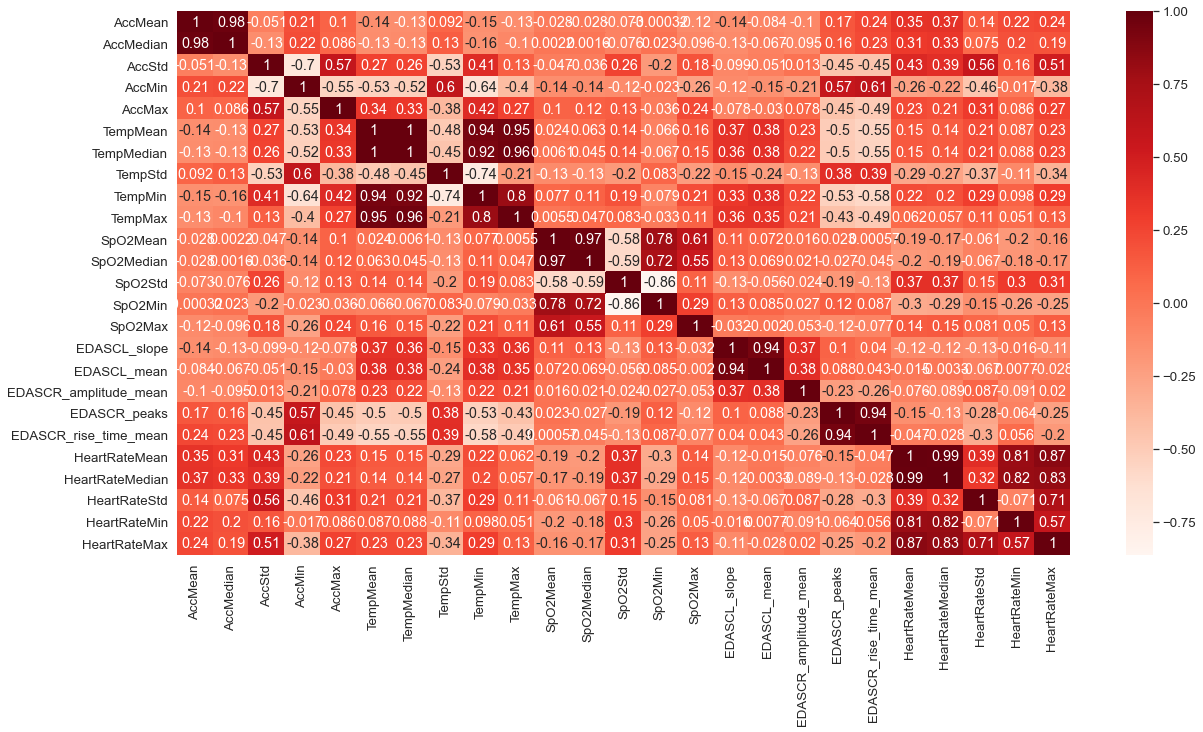

In [82]:
X = features.drop('Label', axis = 1)
X = X.drop('SubjectID', axis = 1)

cor = X.corr()
plt.rcParams["figure.figsize"] = (20,10)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### Strongly correlated features that are removed

In [83]:
features = features.drop('TempMedian', axis = 1)
features = features.drop('HeartRateMedian', axis = 1)
features = features.drop('AccMedian', axis = 1)

In [84]:
X = features.drop('Label', axis=1)
X = X.drop('SubjectID', axis=1)
y = features['Label']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
print(X_train)  
print(y_train)

      AccMean    AccStd    AccMin    AccMax   TempMean   TempStd  TempMin  \
9    1.129547  0.081057  0.646993  1.860242  31.572020  0.324036     30.8   
2    1.156814  0.123338  0.521632  2.119929  32.514971  0.138124     32.2   
136  1.190926  0.032385  0.814494  1.735627  29.066722  1.177078     26.4   
134  1.050389  0.074425  0.579483  2.016978  33.958466  0.737046     31.8   
24   1.104552  0.004335  1.084528  1.126854  29.882585  1.635631     27.0   
..        ...       ...       ...       ...        ...       ...      ...   
70   1.044383  0.053420  0.374433  1.933313  32.519782  0.126447     32.2   
93   1.160805  0.072752  0.637024  2.086289  30.708831  0.132241     30.4   
73   1.192342  0.004959  1.169829  1.214496  29.517534  1.159607     27.0   
98   1.123370  0.117474  0.590339  2.665277  32.087257  0.114885     31.8   
8    1.053937  0.065045  0.601664  1.889894  33.011516  0.357463     31.8   

     TempMax   SpO2Mean  SpO2Median  ...  SpO2Max  EDASCL_slope  EDASCL_mea

### Dimensionality Reduction

/home/spock/.local/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/spock/.local/lib/python3.8/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11046 samples in 0.010s...
[t-SNE] Computed neighbors for 11046 samples in 0.415s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11046
[t-SNE] Computed conditional probabilities for sample 2000 / 11046
[t-SNE] Computed conditional probabilities for sample 3000 / 11046
[t-SNE] Computed conditional probabilities for sample 4000 / 11046
[t-SNE] Computed conditional probabilities for sample 5000 / 11046
[t-SNE] Computed conditional probabilities for sample 6000 / 11046
[t-SNE] Computed conditional probabilities for sample 7000 / 11046
[t-SNE] Computed conditional probabilities for sample 8000 / 11046
[t-SNE] Computed conditional probabilities for sample 9000 / 11046
[t-SNE] Computed conditional probabilities for sample 10000 / 11046
[t-SNE] Computed conditional probabilities for sample 11000 / 11046
[t-SNE] Computed conditional probabilities for sample 11046 / 11046
[t-SNE] Mean sigma: 0.073902
[t-SNE] KL divergence

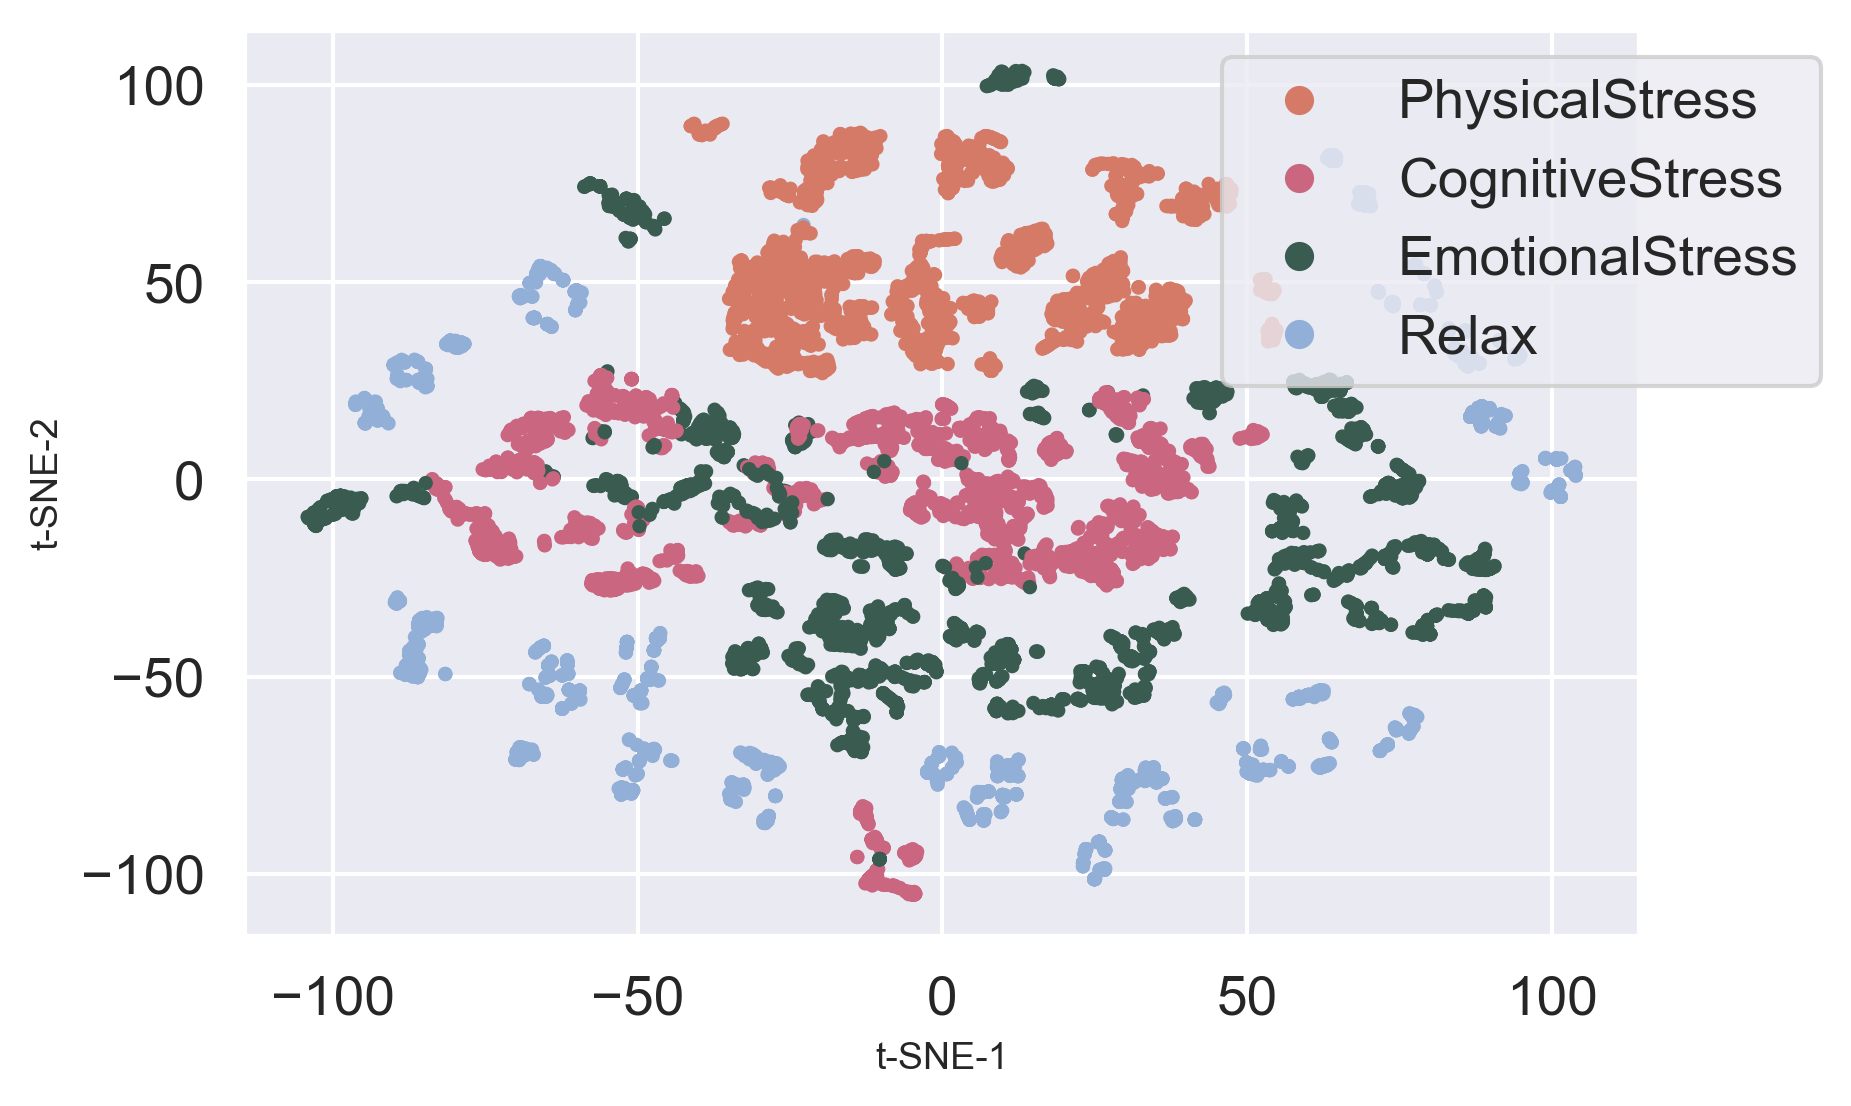

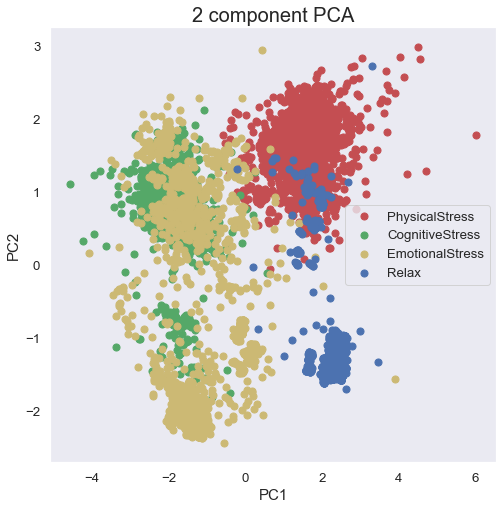

In [105]:
subject10 = total_data[total_data['SubjectID']=='Subject10']
f_names = subject10[ subject10['Label'] == 'Relax2' ].index
subject10.drop(f_names, inplace = True)
f_names = subject10[ subject10['Label'] == 'Relax3' ].index
subject10.drop(f_names, inplace = True)
f_names = subject10[ subject10['Label'] == 'Relax4' ].index
subject10.drop(f_names, inplace = True)
subject10.Label = subject10.Label.str.replace('Relax1', 'Relax')

subject10X = subject10.drop('Label', axis = 1)
subject10X = subject10X.drop('DateTime', axis = 1)
subject10X = subject10X.drop('Hour', axis = 1)
subject10X = subject10X.drop('Minute', axis = 1)
subject10X = subject10X.drop('Second', axis = 1)
subject10X = subject10X.drop('SubjectID', axis = 1)

standardized_10X = StandardScaler().fit_transform(subject10X)

subject10_labels = subject10['Label']
subject10_labels = subject10_labels.reset_index()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(standardized_10X)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

finalDF = pd.concat((principalDF, subject10_labels), axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = set(subject10['Label'])
colors = ['r', 'g', 'y', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDF['Label'] == target
    ax.scatter(finalDF.loc[indicesToKeep, 'PC1']
               , finalDF.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(standardized_10X)
principalDF = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])

fig = px.scatter_3d(
    principalComponents, x=0, y=1, z=2, color=subject10['Label'],
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

tsne_em = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(standardized_10X)
cluster.tsneplot(score=tsne_em)
color_class = subject10['Label'].to_numpy()
cluster.tsneplot(score=tsne_em, colorlist=color_class, colordot=('#d57a66', '#ca6680', '#395B50', '#92AFD7'), legendpos='upper right', legendanchor=(1.15, 1) )

Image(filename='tsne_2d.png') 

### Automated feature selection with sklearn

In [110]:
rfc = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)

sklearn_selector = RFE(rfc, n_features_to_select=6)
X_trans = sklearn_selector.fit_transform(X_train, y_train)

print("Ranking: ", sklearn_selector.ranking_)

selected_features = pd.DataFrame({'Feature': list(X_train.columns),
                                     'Ranking': sklearn_selector.ranking_})

print("\nSelected Features")
print(selected_features.sort_values(by='Ranking').head(n=6))

X_important_train = sklearn_selector.transform(np.array(X_train))
X_important_test = sklearn_selector.transform(np.array(X_test))


rf_sklearn = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
rf_sklearn.fit(X_important_train, y_train)

print("\nAccuracy Score")
accuracy_score(y_test, rf_sklearn.predict(X_important_test))

Ranking:  [10  1  3  6  2  1  1 11  9 14 13 16 17  8 12  5  7  1  4  1 15  1]

Selected Features
                  Feature  Ranking
21           HeartRateMax        1
1                  AccStd        1
5                 TempStd        1
6                 TempMin        1
19           HeartRateStd        1
17  EDASCR_rise_time_mean        1

Accuracy Score


0.9375

### Confusion Matrix of Random Forest Classification

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

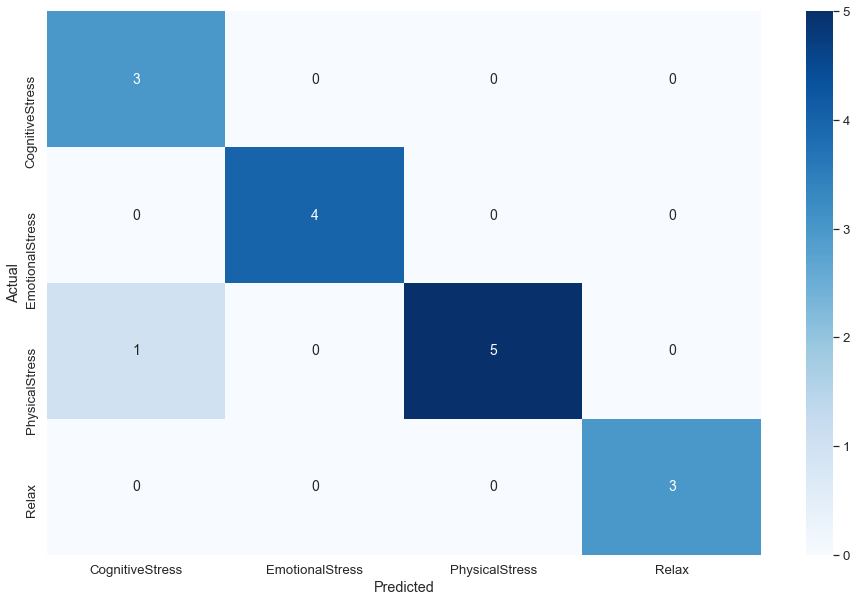

In [107]:
data = confusion_matrix(y_test, rf_sklearn.predict(X_important_test))
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (16,10))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 14})